# Robustness Analysis of Hierarchical Object Detection Models

This notebook analyzes the output of robustness tests to investigate how hierarchical models degrade under various image corruptions.

**Hypothesis:** As image corruption increases, models will gracefully degrade by making more predictions for general ancestor classes rather than specific leaf nodes.

**Methodology:**
1.  **Configure Models:** Specify the paths to the robustness test results for each model to be analyzed.
2.  **Process Raw Data:** The notebook will load the raw prediction `.pkl` files generated by `test_robustness.py`.
3.  **Calculate Hierarchical Statistics:** For each model, corruption, and severity level, it calculates the distribution of predictions (True Positives, Parent, Sibling, False Negatives, etc.).
4.  **Visualize Trends:** Interactive plots are generated to visualize how the prediction distribution changes across corruption severities for different models.

## Project Setup

The following cell adds the project's root directory to the Python path. This is a necessary step to ensure that the notebook can import modules from the `tools` and `hod` directories, as it's located in a subdirectory.

In [2]:
import sys
import os

# Add project root to the Python path
# This allows importing from the 'tools' and 'hod' directories
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(project_root)

In [3]:
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mmengine import Config
from mmengine.registry import init_default_scope
from mmengine.utils import ProgressBar
from mmdet.registry import DATASETS
from hod.utils.tree import HierarchyTree
from collections import defaultdict
import warnings

# Suppress specific warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning, message=".*Creating a tensor from a list of numpy.ndarrays is slow.*")

# Initialize the default scope for MMDetection
init_default_scope('mmdet')

## 1. Configuration

**Action Required:** Update the `MODELS_TO_ANALYZE` dictionary below.

- **Keys:** A short, descriptive name for each model that will be used as a label in the plots.
- **Values:** A dictionary containing:
    - `config`: The path to the model's configuration file.
    - `results_path`: The path to the directory containing the raw robustness prediction files (e.g., `outputs/robustness/dino_hier_aircraft/`).

In [38]:
MODELS_TO_ANALYZE = {
    "DINO-H": {
        "config": "configs/hod/models/hierarchical_dino/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "results_path": "outputs/robustness/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func"
    },
    "DINO-E": {
        "config": "configs/hod/models/embedding_dino/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "results_path": "outputs/robustness/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func"
    },
    "DINO-Flat": {
        "config": "configs/hod/models/dino/dino-r50_improved_8xb2-36e_aircraft-func.py",
        "results_path": "outputs/robustness/dino-r50_improved_8xb2-36e_aircraft-func"
    },
}

## 2. Helper Functions

These functions are adapted from the `hierarchical_prediction_distribution.py` script to process the raw prediction data and calculate the hierarchical statistics.

In [39]:
from tools.analysis_tools.hierarchical_prediction_distribution import (
    calculate_confusion_matrix,
    calculate_hierarchical_prediction_distribution
)

## 3. Data Processing

This section iterates through the configured models and their result files, calculates the statistics for each corruption and severity level, and compiles them into a single DataFrame.

In [43]:
all_stats = []

for model_name, model_info in MODELS_TO_ANALYZE.items():
    print(f"Processing model: {model_name}...")
    
    config_path = model_info['config']
    results_path = Path(model_info['results_path'])
    
    if not results_path.exists():
        print(f"  WARNING: Results path not found, skipping: {results_path}")
        continue
        
    # Load config and build dataset
    cfg = Config.fromfile(config_path)
    dataset = DATASETS.build(cfg.test_dataloader.dataset)
    
    # Find all result files
    result_files = list(results_path.glob('*.pkl'))
    prog_bar = ProgressBar(len(result_files))
    
    for pkl_file in result_files:
        # Extract corruption and severity from filename
        parts = pkl_file.stem.split('_sev')
        if len(parts) != 2:
            continue # Skip files not matching the expected format
            
        corruption = parts[0].replace('_', ' ').title()
        severity = int(parts[1])
        
        # Load results
        with open(pkl_file, 'rb') as f:
            results = pickle.load(f)
            
        # Calculate stats
        confusion_matrix = calculate_confusion_matrix(dataset, results, score_thr=0.3, tp_iou_thr=0.5)
        hierarchical_stats = calculate_hierarchical_prediction_distribution(dataset, confusion_matrix)
        
        # Store the 'Total' stats
        total_stats = hierarchical_stats['Total']
        total_stats['model'] = model_name
        total_stats['corruption'] = corruption
        total_stats['severity'] = severity
        all_stats.append(total_stats)
        prog_bar.update()

# Create DataFrame
df = pd.DataFrame(all_stats)

print("\nProcessing complete.")
if not df.empty:
    print("DataFrame created with the following columns:")
    print(df.columns)
else:
    print("No data was processed. Please check your `MODELS_TO_ANALYZE` configuration.")

Processing model: DINO-H...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 1.1 task/s, elapsed: 5s, ETA:     0s                                               ] 0/6, elapsed: 0s, ETA:[                                                  ] 0/1295, elapsed: 0s, ETA:[                                                  ] 0/1295, elapsed: 0s, ETA:[                                                  ] 0/1295, elapsed: 0s, ETA:[                                                  ] 0/1295, elapsed: 0s, ETA:[                                                  ] 0/1295, elapsed: 0s, ETA:[                                                  ] 0/1295, elapsed: 0s, ETA:[                                                  ] 0/1295, elapsed: 0s, ETA:[                                                  ] 0/1295, elapsed: 0s, ETA:[                                                  ] 0/1295, elapsed: 0s, ETA:[                                    

In [44]:
df.head()

,total_gt,tp,parent_tp,grandparent_tp,sibling_tp,cousin_tp,ancestor_tp,distance,fn,fp_bg,...,sibling_percentage,cousin_percentage,ancestor_percentage,fn_percentage,other_class_percentage,avg_distance,other_class,model,corruption,severity
0,2297.0,1088.0,379.0,199.0,26.0,76.0,121.0,1175.0,202.0,31.0,...,1.131911,3.308663,5.267741,8.794079,8.968219,1.680973,206.0,DINO-H,Motion Blur,2
1,2297.0,874.0,389.0,224.0,42.0,104.0,120.0,1249.0,272.0,39.0,...,1.828472,4.527645,5.224205,11.841532,11.841532,1.703956,272.0,DINO-H,Motion Blur,3
2,2297.0,1216.0,394.0,185.0,29.0,67.0,67.0,993.0,162.0,29.0,...,1.262516,2.916848,2.916848,7.052677,7.705703,1.537152,177.0,DINO-H,Motion Blur,1
3,2297.0,509.0,348.0,163.0,68.0,146.0,177.0,1291.0,552.0,37.0,...,2.960383,6.356117,7.705703,24.031345,14.540705,1.876453,334.0,DINO-H,Motion Blur,5
4,2297.0,1298.0,369.0,164.0,28.0,57.0,63.0,916.0,153.0,29.0,...,1.218981,2.481498,2.742708,6.660862,7.183283,1.536913,165.0,DINO-H,Motion Blur,0


## 4. Visualization: A Three-Part Story

To clearly demonstrate the robustness of the hierarchical model, we'll analyze the results in three stages:

1.  **Aggregate Analysis:** A high-level view averaging performance across all 15 corruptions to show the overall trend. This plot will give us a general sense of how each model behaves under stress.
2.  **Spotlight Analysis:** A focused look at a few realistic, hand-picked corruptions (e.g., 'Fog', 'Motion Blur'). This provides specific evidence of the hierarchical model's graceful degradation in common scenarios.
3.  **Comprehensive Analysis:** The full, detailed breakdown for every corruption type, allowing for a deep dive into the performance on any specific benchmark.

This approach will build a clear and compelling narrative, starting with a broad overview and progressively zooming in on the details.

### Part 1: Aggregate Analysis (Average Across All Corruptions)

This first plot shows the prediction distribution for each model, averaged across all 15 benchmark corruptions. It provides a clear, high-level summary of how each model's predictions shift as corruption severity increases. We expect to see the hierarchical model trade "Correct as Leaf" predictions for "Predicted as Parent" or other ancestor classes, while the flat model shifts more heavily into "Missed (FN)" or "Other Misclassification."

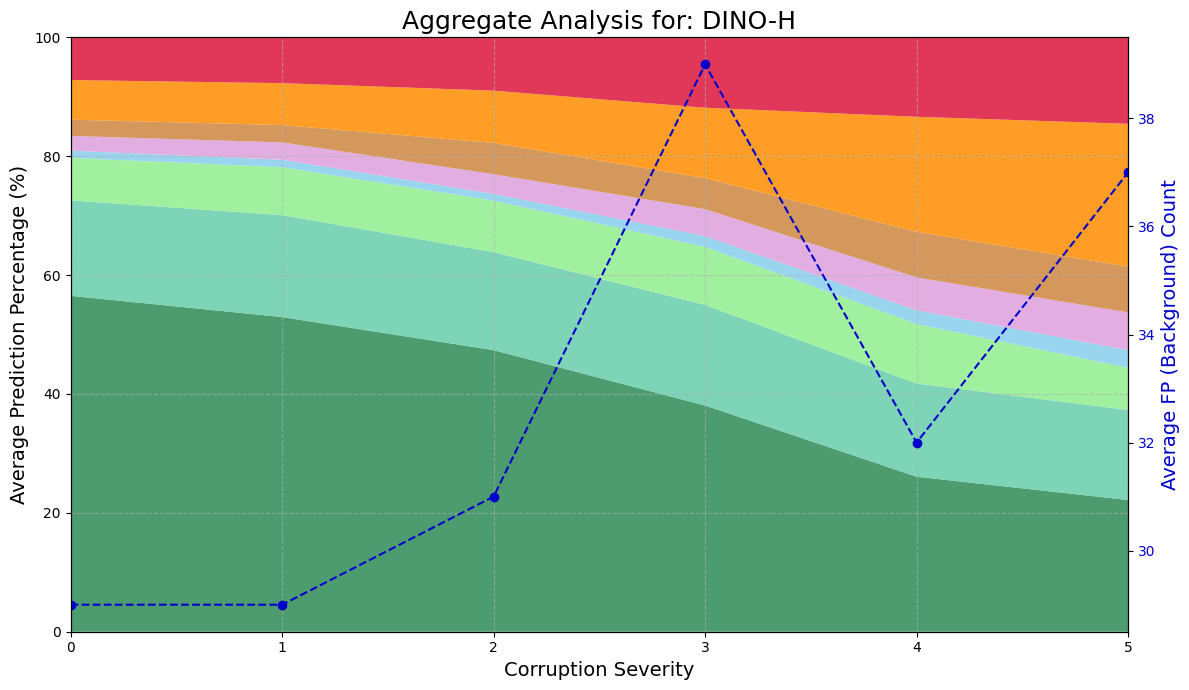

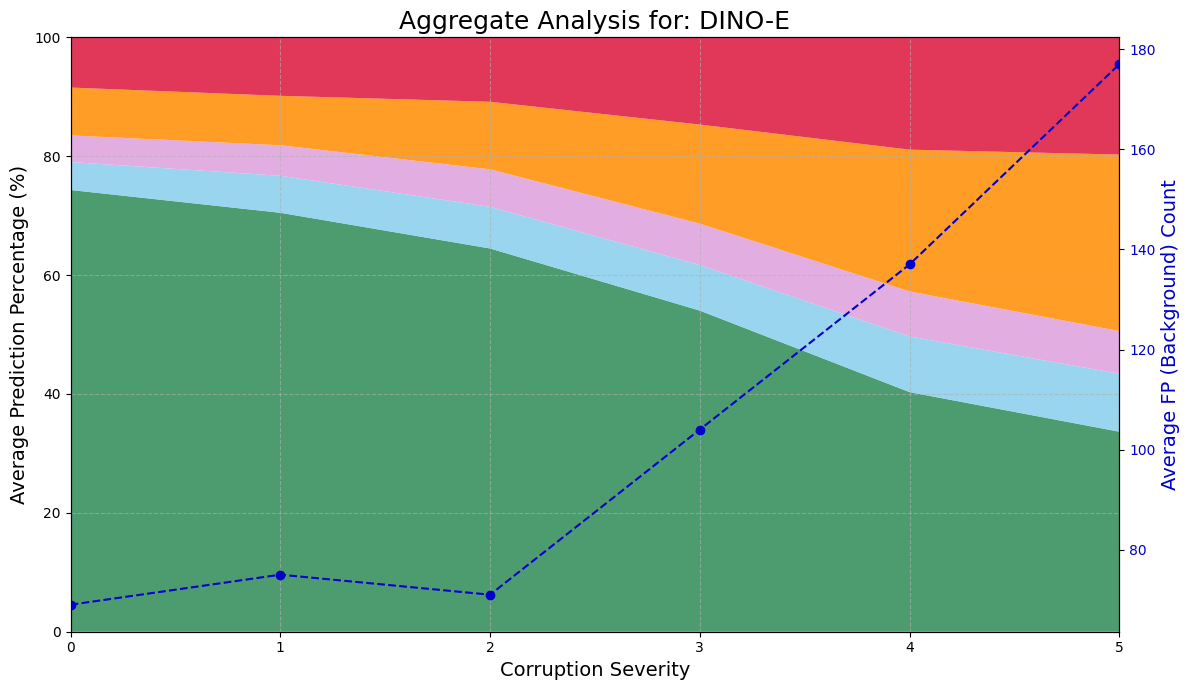

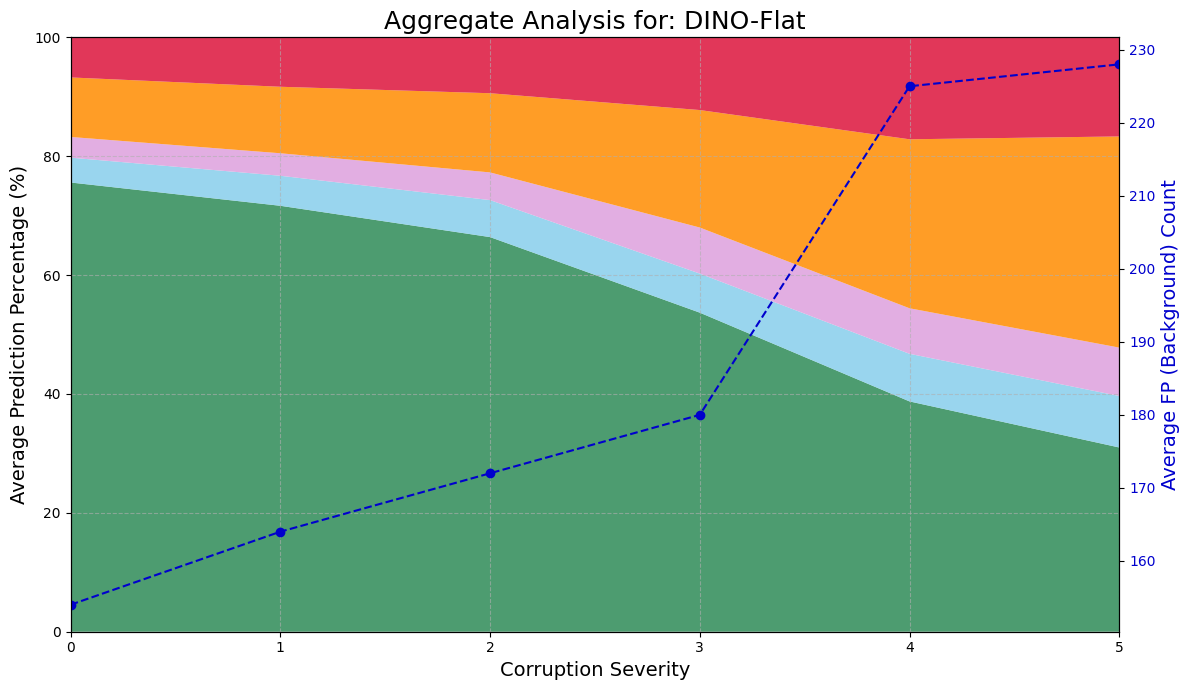

In [45]:
if not df.empty:
    # Define the order, labels, and colors for plotting to be consistent with the analysis script.
    plot_order = [
        'tp_percentage', 
        'parent_percentage', 
        'grandparent_percentage', 
        'sibling_percentage', 
        'cousin_percentage', 
        'ancestor_percentage', 
        'fn_percentage', 
        'other_class_percentage'
    ]
    
    plot_labels = {
        'tp_percentage': 'Correct as Leaf',
        'parent_percentage': 'Predicted as Parent',
        'grandparent_percentage': 'Predicted as Grandparent',
        'sibling_percentage': 'Predicted as Sibling',
        'cousin_percentage': 'Predicted as Cousin',
        'ancestor_percentage': 'Predicted as Other Ancestor',
        'fn_percentage': 'Missed (FN)',
        'other_class_percentage': 'Other Misclassification',
        'fp_bg': 'FP (Background)'
    }

    plot_colors = {
        'tp_percentage': '#2E8B57',
        'parent_percentage': '#66CDAA',
        'grandparent_percentage': '#90EE90',
        'sibling_percentage': '#87CEEB',
        'cousin_percentage': '#DDA0DD',
        'ancestor_percentage': '#CD853F',
        'fn_percentage': '#FF8C00',
        'other_class_percentage': '#DC143C',
        'fp_bg': '#0000CD'
    }

    # Filter out any metrics that are not present in the DataFrame
    available_metrics = [metric for metric in plot_order if metric in df.columns]
    
    # Calculate the average across all corruptions, including fp_bg
    metrics_to_agg = available_metrics + ['fp_bg']
    aggregate_df = df.groupby(['model', 'severity'])[metrics_to_agg].mean().reset_index()

    # Create a separate plot for each model for better control in publications
    model_names = df['model'].unique()
    
    for model_name in model_names:
        model_df = aggregate_df[aggregate_df['model'] == model_name].sort_values('severity')
        
        if model_df.empty:
            continue

        fig, ax = plt.subplots(figsize=(12, 7))

        x = model_df['severity'].values
        y_arrays = [model_df[metric].values for metric in available_metrics]
        
        labels = [plot_labels[metric] for metric in available_metrics]
        colors = [plot_colors[metric] for metric in available_metrics]
        
        # --- Stacked Area Plot for Percentages ---
        ax.stackplot(x, y_arrays, labels=labels, colors=colors, alpha=0.85)
        
        ax.set_title(f'Aggregate Analysis for: {model_name}', fontsize=18)
        ax.set_xlabel('Corruption Severity', fontsize=14)
        ax.set_ylabel('Average Prediction Percentage (%)', fontsize=14)
        ax.set_ylim(0, 100)
        ax.set_xlim(min(x), max(x))
        ax.grid(True, linestyle='--', alpha=0.6)

        # --- Line Plot for FP count on secondary axis ---
        ax2 = ax.twinx()
        fp_counts = model_df['fp_bg'].values
        fp_label = plot_labels['fp_bg']
        fp_color = plot_colors['fp_bg']
        
        ax2.plot(x, fp_counts, color=fp_color, linestyle='--', marker='o', label=fp_label)
        ax2.set_ylabel('Average FP (Background) Count', fontsize=14, color=fp_color)
        ax2.tick_params(axis='y', labelcolor=fp_color)
        
        # Combine legends
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        # ax.legend(lines + lines2, labels + labels2, loc='upper left')

        fig.tight_layout()
        plt.show()
else:
    print("DataFrame is empty. Cannot generate aggregate plot.")

### Universal Plotting Legend

To avoid repetition, the legend below defines the color and label for each prediction category used in all subsequent plots in this notebook.

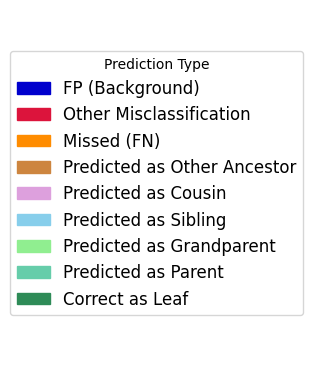

In [13]:
# This cell generates a standalone legend to be used as a reference for all plots.
if not df.empty:
    # Add FP to the labels and colors if not already present
    if 'fp_bg' not in plot_labels:
        plot_labels['fp_bg'] = 'FP (Background)'
        plot_colors['fp_bg'] = '#0000CD'
    
    # Create a dummy figure to host the legend
    fig_legend = plt.figure(figsize=(3, 4.5))
    ax_legend = fig_legend.add_subplot(111)
    
    # Create dummy plot elements for the legend, including FP
    legend_metrics = available_metrics + ['fp_bg']
    handles = [plt.Rectangle((0,0),1,1, color=plot_colors[metric]) for metric in legend_metrics]
    labels = [plot_labels[metric] for metric in legend_metrics]
    
    # Add the legend to the dummy plot
    ax_legend.legend(list(reversed(handles)), reversed(labels), loc='center', title="Prediction Type", fontsize=12)
    
    # Hide the axes
    ax_legend.axis('off')
    
    plt.show()

### Part 2: Spotlight Analysis (Realistic Corruptions)

Here we focus on a few realistic corruptions: **Fog**, **Motion Blur**, and **Gaussian Noise**. These represent common real-world challenges. This focused view allows us to see if the graceful degradation trend holds for specific, practical scenarios.

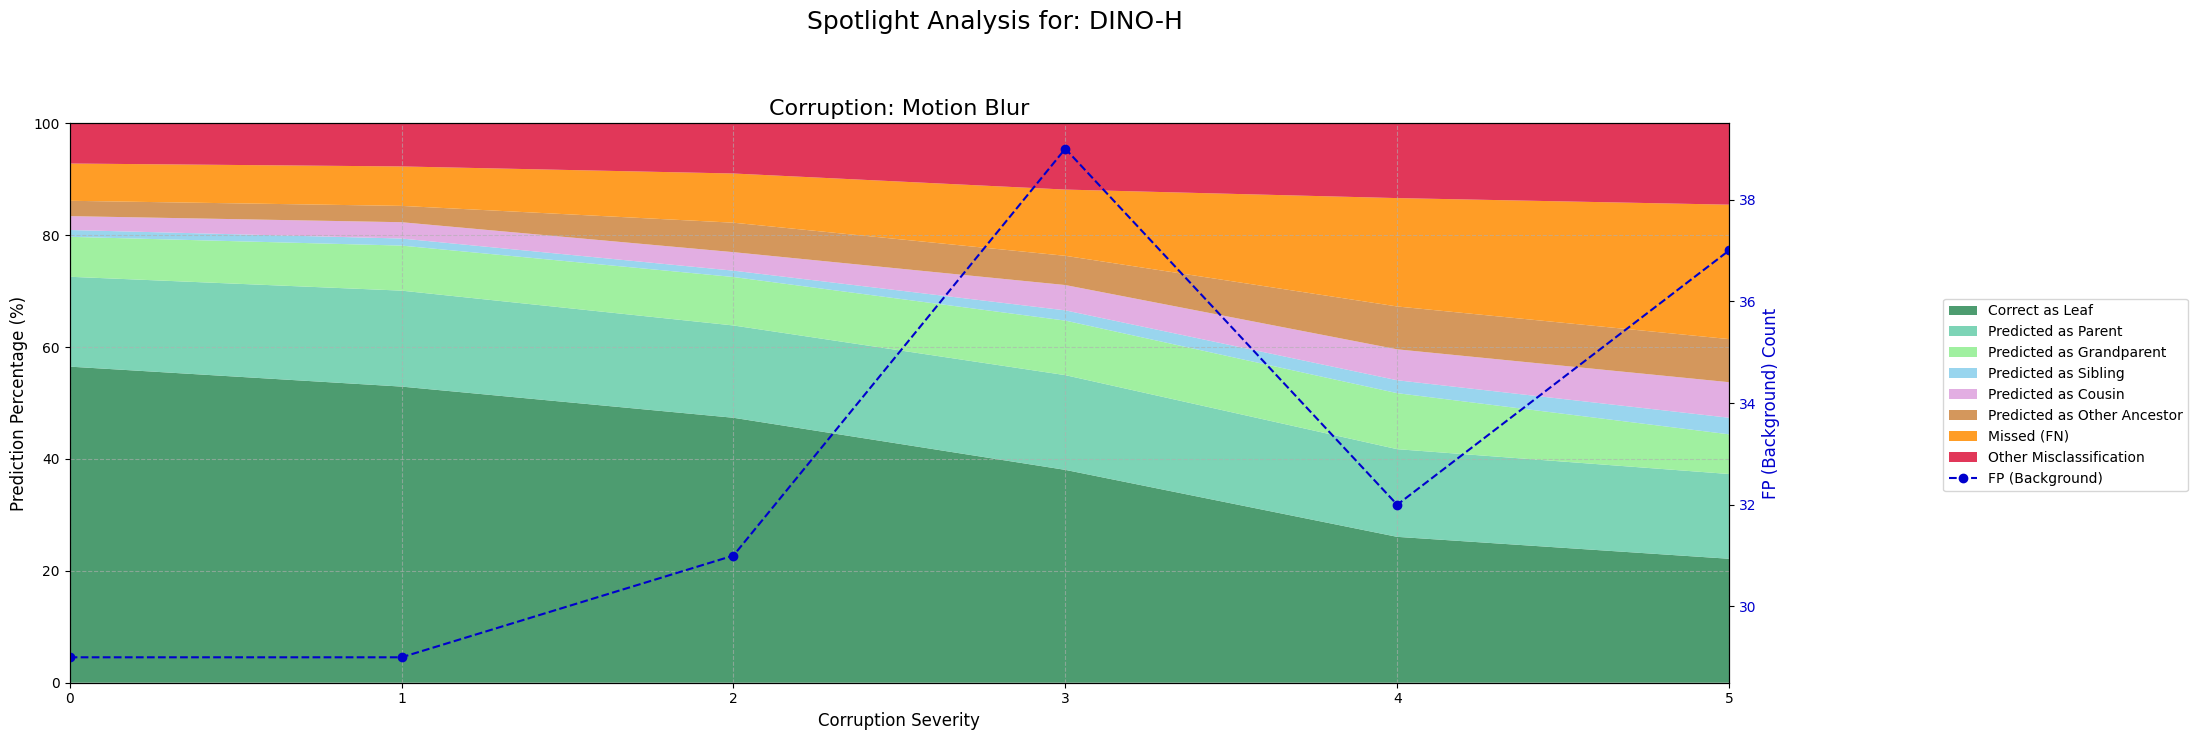

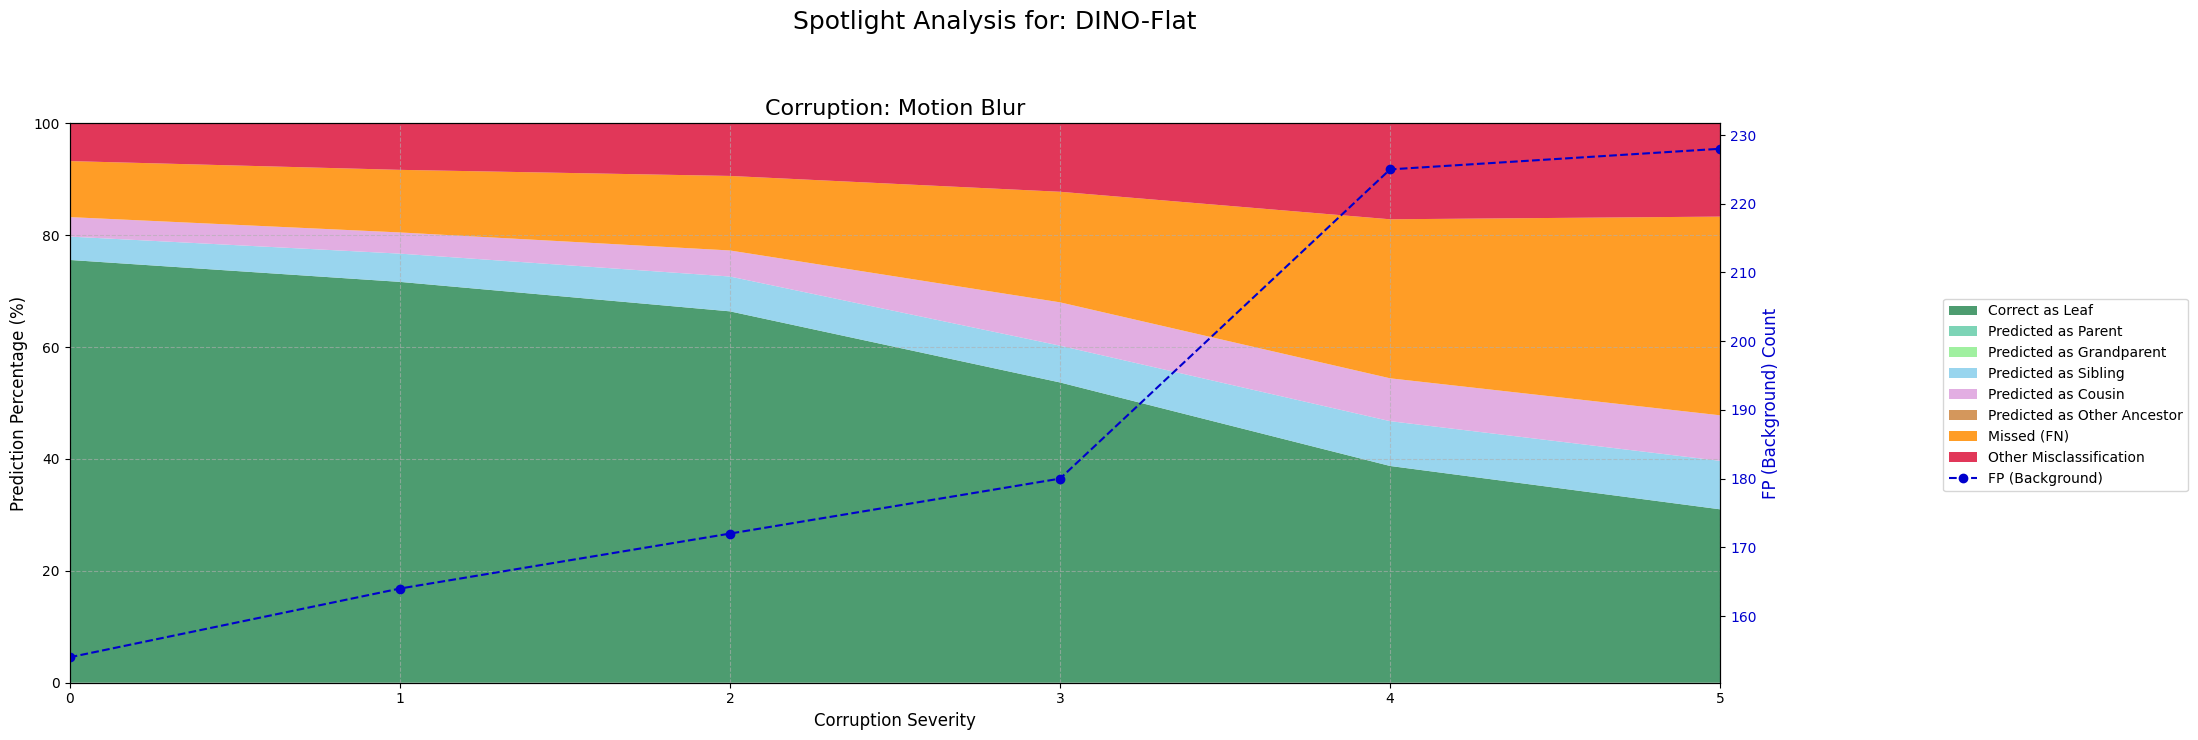

In [17]:
if not df.empty:
    spotlight_corruptions = ['Fog', 'Motion Blur', 'Gaussian Noise']
    spotlight_df = df[df['corruption'].isin(spotlight_corruptions)]

    if not spotlight_df.empty:
        for model_name in spotlight_df['model'].unique():
            model_df = spotlight_df[spotlight_df['model'] == model_name].copy()
            
            corruption_types = sorted(model_df['corruption'].unique())
            num_corruptions = len(corruption_types)
            
            if num_corruptions == 0:
                continue

            fig, axes = plt.subplots(
                nrows=1, 
                ncols=num_corruptions, 
                figsize=(20, 7), # Increased figure size for better legend placement
                sharey=True,
                squeeze=False
            )
            axes = axes.flatten()

            fig.suptitle(f'Spotlight Analysis for: {model_name}', fontsize=18, y=1.05)

            for i, corruption_name in enumerate(corruption_types):
                ax = axes[i]
                corruption_df = model_df[model_df['corruption'] == corruption_name].sort_values('severity')
                
                x = corruption_df['severity'].values
                y_arrays = [corruption_df[metric].values for metric in available_metrics]
                
                labels = [plot_labels[metric] for metric in available_metrics]
                colors = [plot_colors[metric] for metric in available_metrics]
                
                # --- Stacked Area Plot for Percentages ---
                ax.stackplot(x, y_arrays, labels=labels, colors=colors, alpha=0.85)
                
                ax.set_title(f'Corruption: {corruption_name}', fontsize=16)
                ax.set_xlabel('Corruption Severity', fontsize=12)
                ax.set_ylim(0, 100)
                ax.set_xlim(min(x), max(x))
                ax.grid(True, linestyle='--', alpha=0.6)

                # --- Line Plot for FP count on secondary axis ---
                ax2 = ax.twinx()
                fp_counts = corruption_df['fp_bg'].values
                fp_label = plot_labels['fp_bg']
                fp_color = plot_colors['fp_bg']
                
                ax2.plot(x, fp_counts, color=fp_color, linestyle='--', marker='o', label=fp_label)
                ax2.set_ylabel('FP (Background) Count', fontsize=12, color=fp_color)
                ax2.tick_params(axis='y', labelcolor=fp_color)

            axes[0].set_ylabel('Prediction Percentage (%)', fontsize=12)
            
            # Create a single shared legend for the figure
            lines, labels = axes[0].get_legend_handles_labels()
            # Get handles from the last created secondary axis
            lines2, labels2 = fig.axes[-1].get_legend_handles_labels()
            fig.legend(lines + lines2, labels + labels2, loc='center right', bbox_to_anchor=(1.1, 0.5))

            fig.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout for legend
            plt.show()
    else:
        print("No data found for spotlight corruptions.")
else:
    print("DataFrame is empty. Cannot generate spotlight plots.")

### Part 3: Comprehensive Analysis (All Corruptions)

The following plots provide a detailed, comprehensive view of the performance for each model across all 15 benchmark corruptions. This allows for a thorough investigation of how models react to every type of image degradation tested.

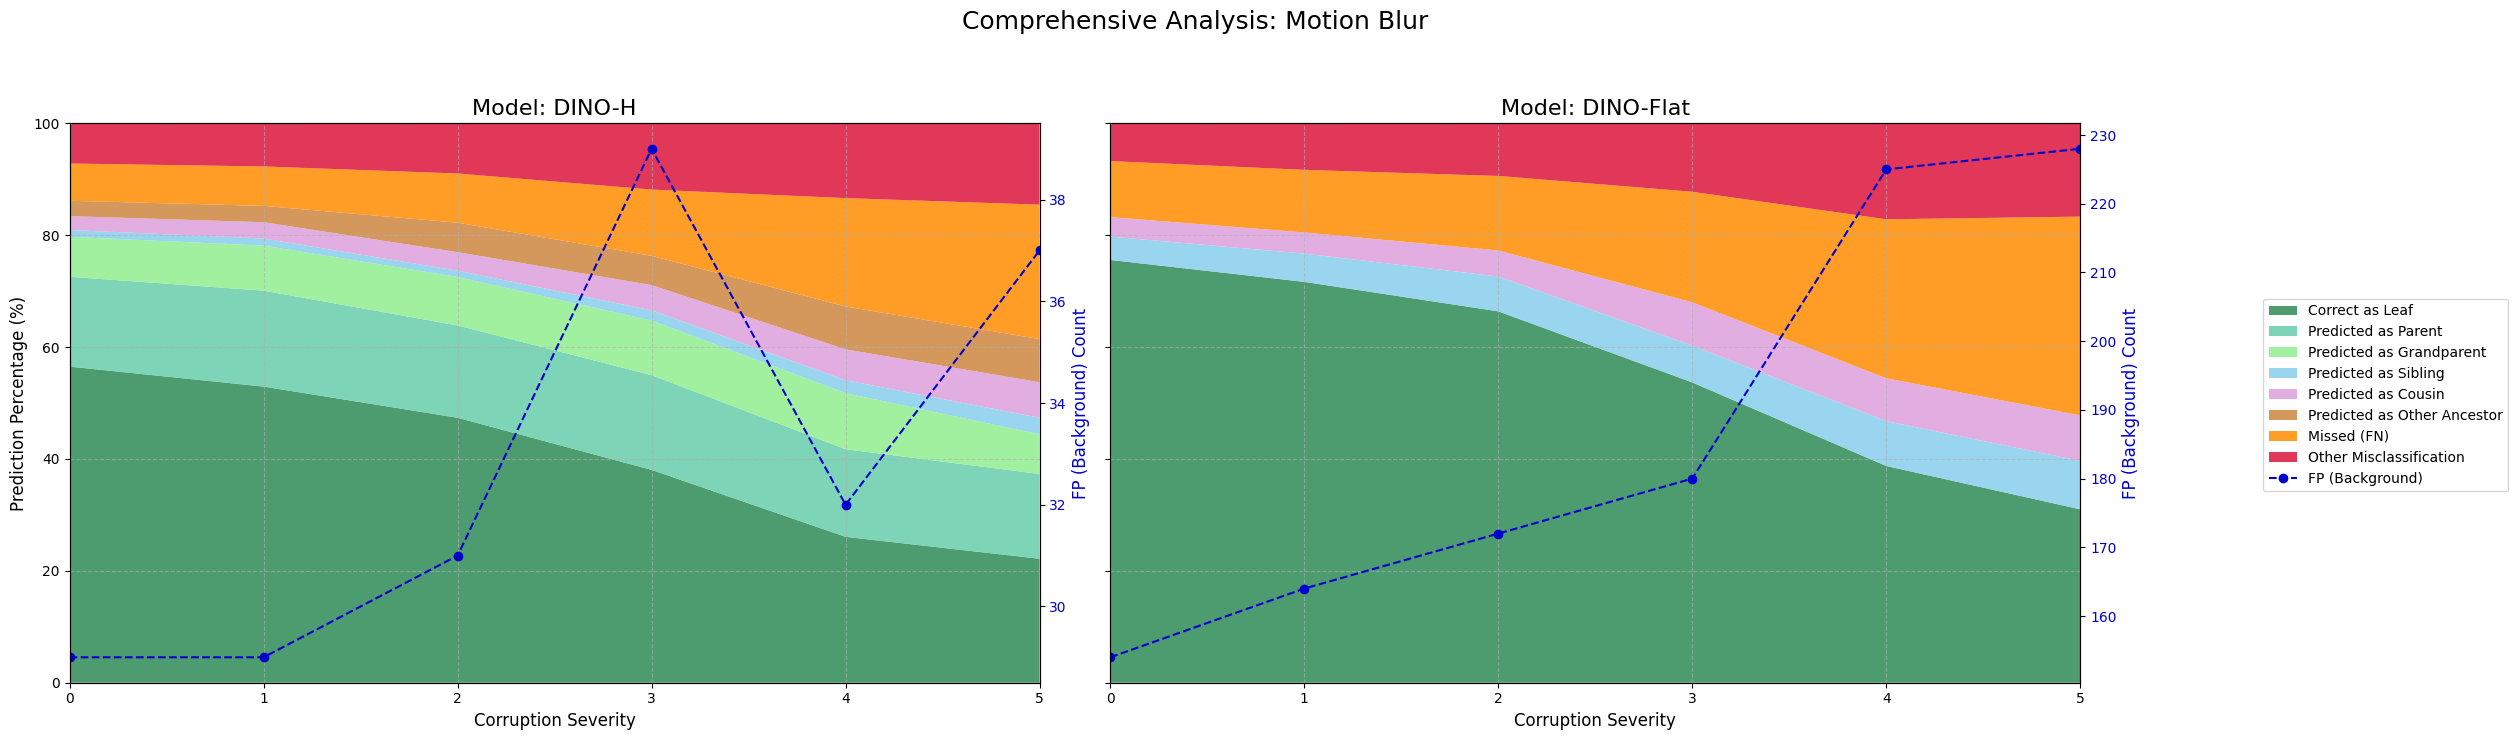

In [15]:
if not df.empty:
    corruption_types = sorted(df['corruption'].unique())
    model_names = df['model'].unique()
    num_models = len(model_names)

    # Generate a separate figure for each corruption type
    for corruption_name in corruption_types:
        fig, axes = plt.subplots(
            nrows=1, 
            ncols=num_models, 
            figsize=(12 * num_models, 7), # Increased width for legend
            sharey=True
        )
        if num_models == 1:
            axes = [axes] # Make it iterable

        fig.suptitle(f'Comprehensive Analysis: {corruption_name}', fontsize=18, y=1.05)

        for i, model_name in enumerate(model_names):
            ax = axes[i]
            # Filter data for the specific model and corruption
            plot_df = df[(df['model'] == model_name) & (df['corruption'] == corruption_name)].sort_values('severity')
            
            if plot_df.empty:
                ax.set_title(f'Model: {model_name}\n(No data)')
                continue

            # Prepare data for stackplot
            x = plot_df['severity'].values
            y_arrays = [plot_df[metric].values for metric in available_metrics]
            
            labels = [plot_labels[metric] for metric in available_metrics]
            colors = [plot_colors[metric] for metric in available_metrics]
            
            # --- Stacked Area Plot for Percentages ---
            ax.stackplot(x, y_arrays, labels=labels, colors=colors, alpha=0.85)
            
            ax.set_title(f'Model: {model_name}', fontsize=16)
            ax.set_xlabel('Corruption Severity', fontsize=12)
            ax.set_ylim(0, 100)
            ax.set_xlim(min(x), max(x))
            ax.grid(True, linestyle='--', alpha=0.6)

            # --- Line Plot for FP count on secondary axis ---
            ax2 = ax.twinx()
            fp_counts = plot_df['fp_bg'].values
            fp_label = plot_labels['fp_bg']
            fp_color = plot_colors['fp_bg']
            
            ax2.plot(x, fp_counts, color=fp_color, linestyle='--', marker='o', label=fp_label)
            ax2.set_ylabel('FP (Background) Count', fontsize=12, color=fp_color)
            ax2.tick_params(axis='y', labelcolor=fp_color)

        # Common Y label
        axes[0].set_ylabel('Prediction Percentage (%)', fontsize=12)
        
        # Create a single shared legend for the figure
        lines, labels = axes[0].get_legend_handles_labels()
        # Get handles from the last created secondary axis
        ax2_handles, ax2_labels = fig.axes[-1].get_legend_handles_labels()
        fig.legend(lines + ax2_handles, labels + ax2_labels, loc='center right', bbox_to_anchor=(1.05, 0.5))

        # Adjust layout
        fig.tight_layout(rect=[0, 0, 0.9, 1])
        
        plt.show()
else:
    print("DataFrame is empty. Cannot generate plots.")


### Average Distance Analysis

This plot shows the average hierarchical distance between the ground truth and the miss-classified prediction. A lower distance indicates that the model is making "closer" mistakes (e.g., predicting a parent or sibling).

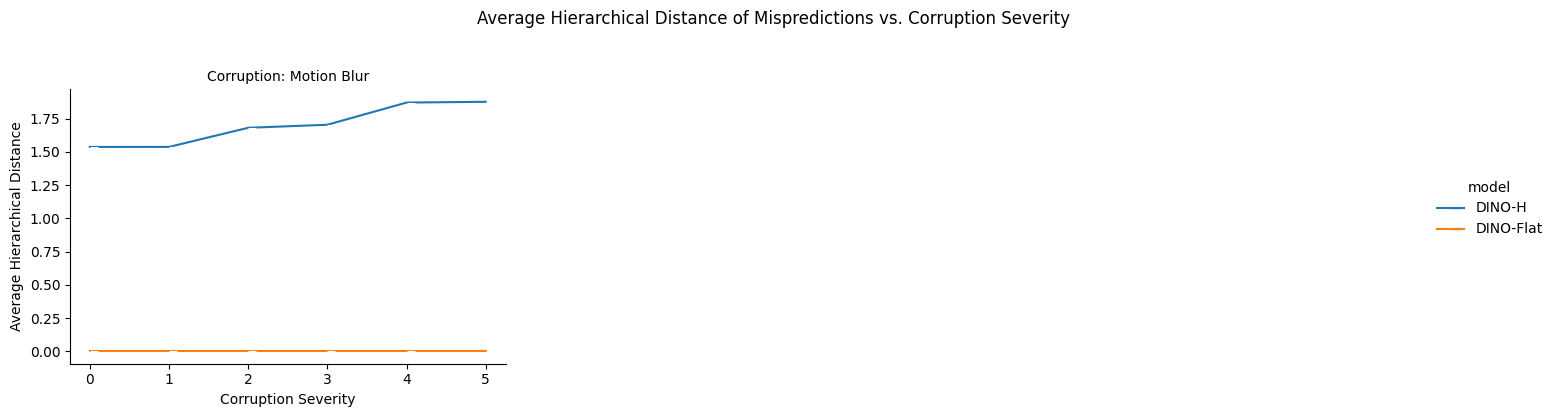

In [16]:
if not df.empty:
    # Create the faceted plot using Seaborn
    g = sns.relplot(
        data=df,
        x='severity',
        y='avg_distance',
        hue='model',
        col='corruption',
        kind='line',
        marker=True,
        col_wrap=3,
        height=4,
        aspect=1.2
    )
    
    g.fig.suptitle('Average Hierarchical Distance of Mispredictions vs. Corruption Severity', y=1.03)
    g.set_axis_labels("Corruption Severity", "Average Hierarchical Distance")
    g.set_titles("Corruption: {col_name}")
    g.tight_layout(w_pad=1)
    
    plt.show()
else:
    print("DataFrame is empty. Cannot generate plots.")